# Unidad 3. Detección de comunidades

In [1]:
import os
import time
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
import igraph as ig

# CAMBIEN LA SIGUIENTE LÍNEA A LA RAÍZ DEL REPOSITORIO EN SU PC
os.chdir("/home/gonzalo/maestria/aag/")

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [2]:
def inline_plot(g, *args, **kwargs):
    """Dibuja un gráfico de `igraph.plot` 'inline' en el notebook."""
    from IPython.display import display, Image
    import os
    ig.plot(g, *args, **kwargs).save("temp.png")
    display(Image(filename="temp.png"))
    os.remove("temp.png")

In [3]:
g = ig.Graph.Famous("Zachary")
g.vs["label"] = [v.index + 1 for v in g.vs]

pal = plt.cm.Pastel1
# https://igraph.org/python/doc/tutorial/tutorial.html#vertex-attributes-controlling-graph-plots
visual= dict(vertex_label_size=8, vertex_size=12, bbox=(300, 300))

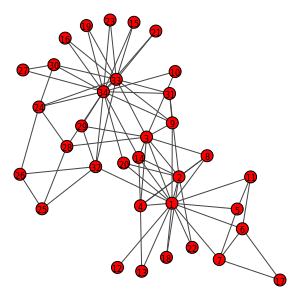

In [4]:
inline_plot(g, **visual)

### VertexDendogram y VertexClustering
Estas dos clases describen las comunidades de un grafo. Todo agrupamiento se puede expresar como un _clustering de vértices_, y todo agrupamiento _jerárquico_ (aglomerativo o divisimo) se puede describir con un _dendograma de vértices_. Especificando una cantidad de _clusters_, un dendograma se puede transformar sencillamente en un clustering.

In [5]:
vd = g.community_fastgreedy()
type(vd)

igraph.clustering.VertexDendrogram

In [6]:
vc = vd.as_clustering()
type(vc)

igraph.clustering.VertexClustering

In [7]:
# Llamar a VertexDendogram.as_clustering sin parámetros es equivalente a llamarlo con la cantidad de clusters "óptima"
list(vd.as_clustering(vd.optimal_count)) == list(vd.as_clustering())

True

### Matriz de similaridad

"Dibujar" la matriz de similaridad sin particular atención al orden de las filas (nodos) no muestra agrupamientos.

In [8]:
sim = np.matrix(g.similarity_dice())

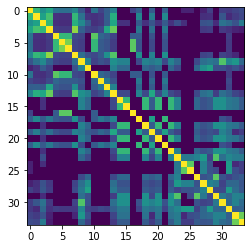

In [9]:
plt.imshow(sim)

La misma matrix, reordenando las filas/columnas (nodos) según las comunidades ques encuentra `fastgreedy` muestra cierta estructura en bloques.

In [10]:
indices = np.argsort(vc.membership)

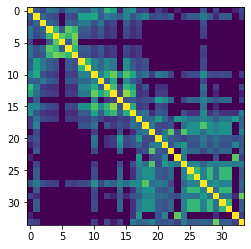

In [11]:
plt.imshow(sim[indices, :][:, indices])

Y más aún si buscamos las comunidades que maximizan la modularidad:

In [12]:
vc = g.community_optimal_modularity()
indices = np.argsort(vc.membership)

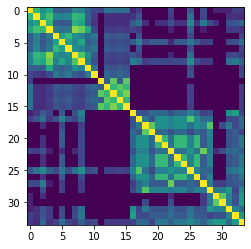

In [13]:
plt.imshow(sim[indices, :][:, indices])

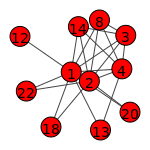

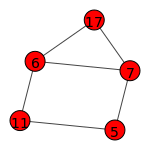

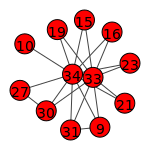

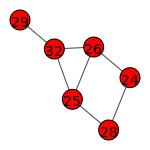

In [14]:
for _g in vc.subgraphs():
    inline_plot(_g, bbox=(150, 150))

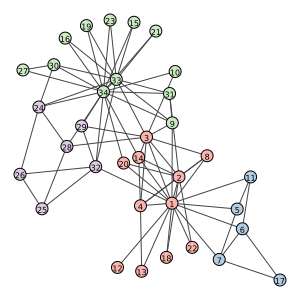

In [15]:
ig.plot(g, vertex_color=[list(x) for x in pal(vc.membership)], **visual)

Idéntico a http://networksciencebook.com/images/ch-09/figure-9-2.jpg !

### Comparación de métodos

Tanto [networkx](https://networkx.org/documentation/stable/reference/algorithms/community.html) como [igraph](https://igraph.org/c/doc/igraph-Community.html) tienen sus respectivos métodos bien documentados. Aquí tomamos todos los métodos de detección de comunidades disponibles en `igraph` y los aplicamos sobre un mismo grafo:

In [16]:
# Los métodos de detección de comunidades de `igraph` son atributos de la clase Graph, y
# sus nombres comienzan siempre con "community_"
prefijo = "community_"
metodos = [m for m in dir(ig.Graph) if m.startswith(prefijo)]

In [17]:
[m for m in metodos]

['community_edge_betweenness',
 'community_fastgreedy',
 'community_infomap',
 'community_label_propagation',
 'community_leading_eigenvector',
 'community_leading_eigenvector_naive',
 'community_leiden',
 'community_multilevel',
 'community_optimal_modularity',
 'community_spinglass',
 'community_walktrap']

In [18]:
resumen = {}
for m in metodos:
    try:
        t0 = time.time()
        dendograma_o_clustering = getattr(g, m)()
        t = time.time() - t0
    except Exception as e:
        print(f"{m} falló con el siguiente error: '{e}'")
        continue
    resultados = resumen[m.replace(prefijo, "")] = {}
    resultados["t"] = t
    if isinstance(dendograma_o_clustering, ig.VertexDendrogram):
        resultados["dendograma"] = dendograma_o_clustering
        clustering = dendograma_o_clustering.as_clustering()
    else:  # dendograma_o_clustering es un VertexClustering
        clustering = dendograma_o_clustering
    resultados["clustering"] = clustering
    resultados["modularidad"] = clustering.q
    resultados["membresia"] = clustering.membership
    # El máximo índice del vector de membresías es 1 menos que la cantidad de clusters total.
    resultados["clusters"] = max(clustering.membership) + 1

community_leading_eigenvector_naive falló con el siguiente error: 'type object 'igraph._igraph.GraphBase' has no attribute 'community_leading_eigenvector_naive''


In [19]:
resumen["infomap"]["clustering"]

In [20]:
# El atributo `q` de un VertexClustering `vc` es exactamente la modularidad del grafo respecto a la membresía de `vc`
vc = resumen["infomap"]["clustering"]
vc.q == g.modularity(vc.membership)

True

In [21]:
df = pd.DataFrame.from_dict(resumen, orient="index")

In [22]:
df[["t", "modularidad", "clusters"]]

,t,modularidad,clusters
edge_betweenness,0.003606,0.401298,5
fastgreedy,0.000088,0.380671,3
infomap,0.005986,0.402038,3
label_propagation,0.000071,0.399080,3
leading_eigenvector,0.004357,0.393409,4
leiden,0.000109,-0.049803,34
multilevel,0.000211,0.418803,4
optimal_modularity,0.343634,0.419790,4
spinglass,0.178655,0.419790,4
walktrap,0.000141,0.353222,5


### Comparación de clusterings

In [23]:
from itertools import combinations

In [24]:
out = []
for a, b in combinations(resumen, 2):
    out.append(
        {
            "metodo_a": a,
            "metodo_b": b,
            "similitud": ig.compare_communities(resumen[a]["membresia"], resumen[b]["membresia"], method="rand")
        }
    )
comp = pd.DataFrame(out)

In [25]:
comp.sort_values("similitud", ascending=False).head(10)

,metodo_a,metodo_b,similitud
42,optimal_modularity,spinglass,1.000000
40,multilevel,spinglass,0.960784
39,multilevel,optimal_modularity,0.960784
17,infomap,label_propagation,0.950089
32,leading_eigenvector,optimal_modularity,0.950089
33,leading_eigenvector,spinglass,0.950089
9,fastgreedy,infomap,0.925134
5,edge_betweenness,multilevel,0.925134
6,edge_betweenness,optimal_modularity,0.925134
7,edge_betweenness,spinglass,0.925134


Pareciera que `optimal_modularity` y `spinglass` dan _exactamente_ las mismas comunidades. Veámoslo gráficamente:

Método: edge_betweenness


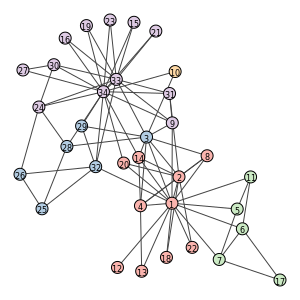

Método: fastgreedy


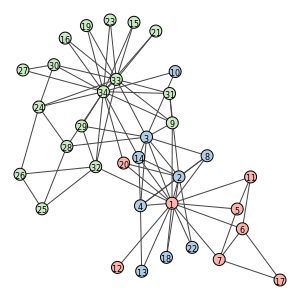

Método: infomap


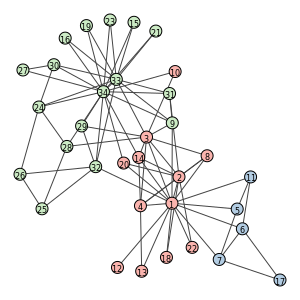

Método: label_propagation


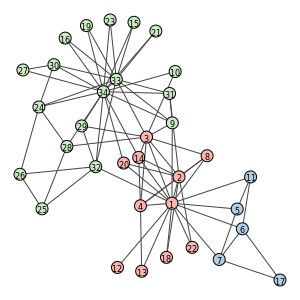

Método: leading_eigenvector


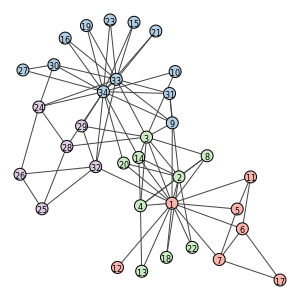

Método: leiden


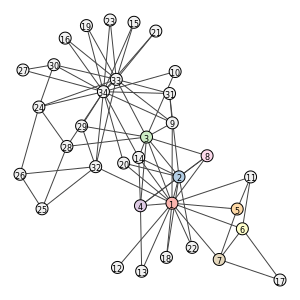

Método: multilevel


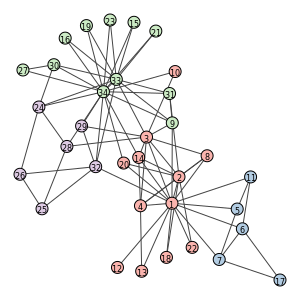

Método: optimal_modularity


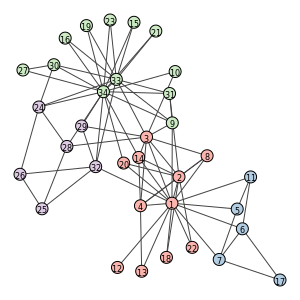

Método: spinglass


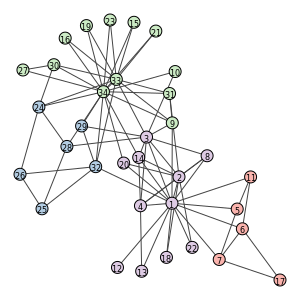

Método: walktrap


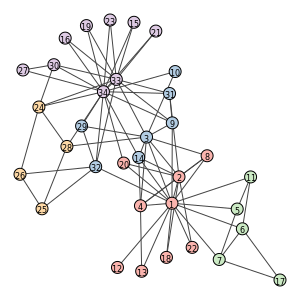

In [26]:
for m, res in resumen.items():
    print(f"Método: {m}")
    inline_plot(g, vertex_color=[list(x) for x in pal(res["membresia"])], **visual)

### Performance: tiempo y calidad

El clustering con la modularidad óptima _es_, por definición, la mejor representación de la estructura de comunidades del grafo. Pero su cómputo por fuerza bruta puede tardar _mucho, pero mucho_ tiempo, así que es importante saber qué algoritmos usar en grafos grandes, dependiendo de
- los recursos de cómputo disponibles y
- la calidad requerida para el clustering resultante.

Aquí, calculamos la estructura de comunidades según cada uno de los métodos anteriores, para grafos aleatorios de entre 10 y 10.000 nodos, y comparamos
- su tiempo de ejecución y
- el coeficiente de modularidad $Q$ obtenido.

In [27]:
ns = np.logspace(1, 4).astype(int)

In [28]:
ns

array([   10,    11,    13,    15,    17,    20,    23,    26,    30,
          35,    40,    47,    54,    62,    71,    82,    95,   109,
         126,   145,   167,   193,   222,   255,   294,   339,   390,
         449,   517,   596,   686,   790,   910,  1048,  1206,  1389,
        1599,  1842,  2120,  2442,  2811,  3237,  3727,  4291,  4941,
        5689,  6551,  7543,  8685, 10000])

In [29]:
grafos = {n: ig.Graph.GRG(n, 0.2) for n in ns}

In [30]:
data = []
for m in metodos:
    logger.info(f"Analizando método {m}")
    for n, g in grafos.items():
        try:
            t0 = time.time()
            ret = getattr(g, m)()
            t = time.time() - t0
    #         logger.info(f"- {n} nodos, {round(t * 1000, 2)}ms")
            data.append(
                dict(
                    metodo=m.replace(prefijo, ""),
                    n=n,
                    ms=1000 * t,
                    q=(ret.q if isinstance(ret, ig.clustering.VertexClustering) else ret.as_clustering().q)
                )
            )
            if t > 1:  # Si el algoritmo tardó más de 1 segundo, cortar aquí la exploración
                break
        except Exception as e:
            logger.error(e)
            break

INFO:root:Analizando método community_edge_betweenness
ERROR:root:Error at src/community/misc.c:115: Number of steps is greater than number of rows in merges matrix: found 8 steps, 6 rows. -- Invalid value
INFO:root:Analizando método community_fastgreedy
INFO:root:Analizando método community_infomap
INFO:root:Analizando método community_label_propagation
INFO:root:Analizando método community_leading_eigenvector
INFO:root:Analizando método community_leading_eigenvector_naive
ERROR:root:type object 'igraph._igraph.GraphBase' has no attribute 'community_leading_eigenvector_naive'
INFO:root:Analizando método community_leiden
INFO:root:Analizando método community_multilevel
INFO:root:Analizando método community_optimal_modularity
INFO:root:Analizando método community_spinglass
ERROR:root:Error at src/community/spinglass/clustertool.cpp:306: Cannot work with unconnected graph. -- Invalid value
INFO:root:Analizando método community_walktrap


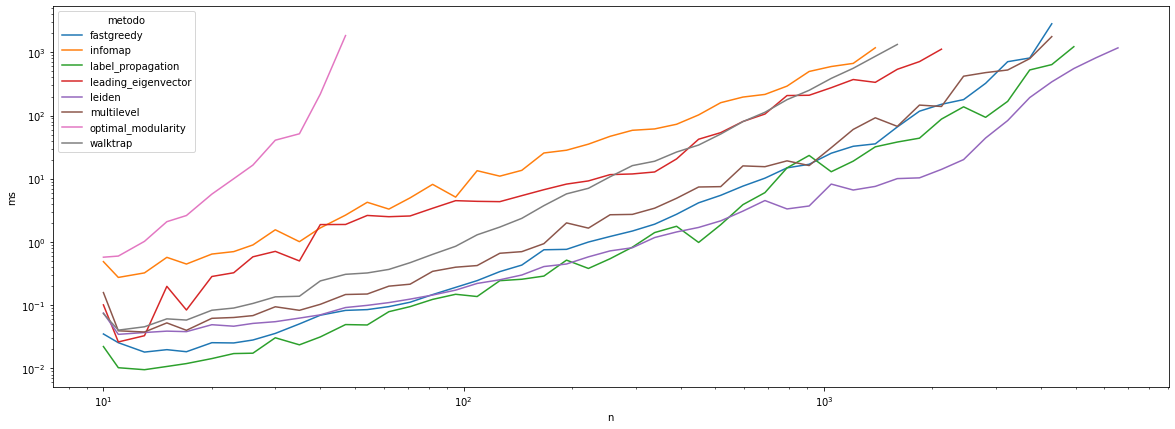

In [31]:
import seaborn as sns
plt.figure(figsize=(20, 7))
sns.lineplot(x="n", y="ms", hue="metodo", data=pd.DataFrame(data))
plt.yscale("log")
plt.xscale("log")

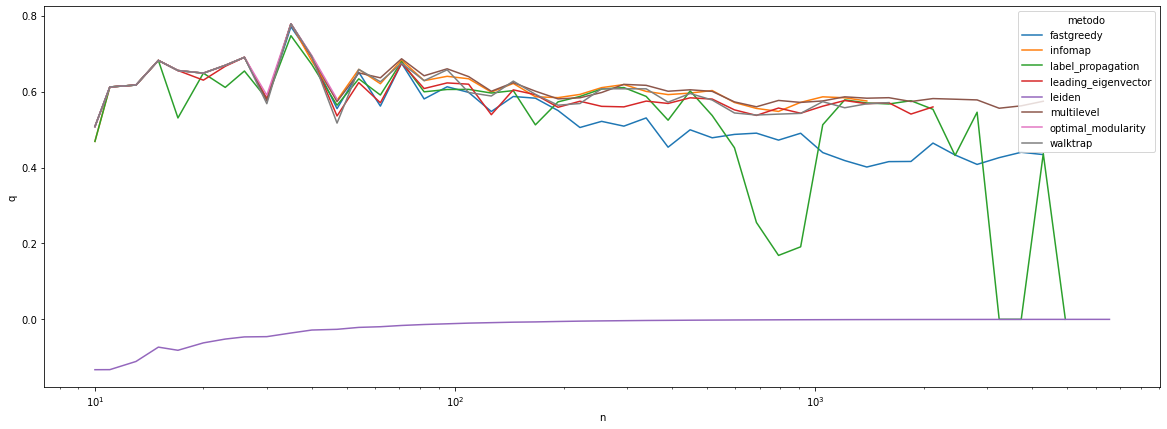

In [45]:
import seaborn as sns
plt.figure(figsize=(20, 7))
sns.lineplot(x="n", y="q", hue="metodo", data=pd.DataFrame(data))
plt.xscale("log")

Esta exploración es un poco pobre. Para enriquecerla, se podría:
- para cada grafo, correr cada algoritmo $k$ veces, y luego promediar los tiempos y el $Q$ resultante.
- explorar los parámetros de cada algoritmo (e.g., `community_leiden` parece ni siquiera andar, pero si pasamos `objective_function='modularity'` de repente sí funciona; seguirá siendo tan rápido entonces?)